# 学習

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import random

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 画素の位置を適当に入れ替える
SHUFFLED_INDICES = list(range(14*14))
random.shuffle(SHUFFLED_INDICES)

class RandomShuffle(object):
    def __call__(self, tensor):
        # num_pixels = tensor.numel()  # 画像の総ピクセル数
        reshaped_tensor = tensor.view(-1)  # 1次元テンソルに変換
        
        # # ピクセルのインデックスをシャッフル
        # shuffled_indices = list(range(num_pixels))
        # random.shuffle(shuffled_indices)
        
        # シャッフルされたインデックスを使用してピクセルの順序を入れ替える
        shuffled_tensor = reshaped_tensor[SHUFFLED_INDICES]
        
        # シャッフル後のテンソルを元の形状に変形して返す
        return shuffled_tensor.view(tensor.size())
        
# データの前処理
transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),
    RandomShuffle(),
])

# MNISTデータセットの読み込み
original_train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
original_test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)


In [2]:
# クラス1のデータのみ抽出
train_dataset = [data for data in original_train_dataset if data[1] == 1]
test_dataset = [data for data in original_test_dataset if data[1] == 1]

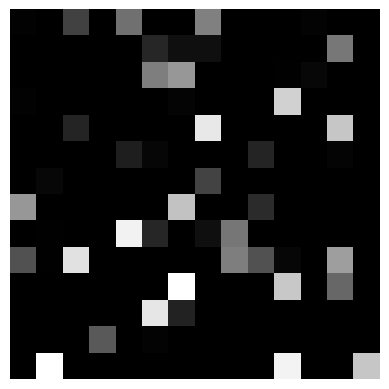

In [3]:
import matplotlib.pyplot as plt
image = train_dataset[0][0].squeeze(0)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [4]:
len(train_dataset)

6742

In [5]:
len(test_dataset)

1135

In [6]:

# DataLoaderの作成
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoderモデルの定義
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # エンコーダ部分
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # torch.Size([*, 16, 7, 7])
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # torch.Size([*, 32, 4, 4])
            nn.ReLU(),
        )
        
        # デコーダ部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=0), # torch.Size([*, 16, 7, 7])
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# モデルのインスタンス化とデバイスへの移動
model = Autoencoder().to(device)

# 損失関数と最適化アルゴリズムの定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習の実行
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = 0.0
    
    # モデルを訓練モードに設定
    model.train()
    
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        
        # 順伝播と逆伝播の計算
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    # エポックごとの損失を出力
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")

# テストデータでの評価
test_loss = 0.0

# モデルを評価モードに設定
model.eval()

def loss_fn(model, images):
    images = images.to(device)
    outputs = model(images)
    loss = criterion(outputs, images)
    return loss

with torch.no_grad():
    for data in test_loader:
        images, _ = data
        loss = loss_fn(model, images)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/10, Training Loss: 0.0736
Epoch 2/10, Training Loss: 0.0237
Epoch 3/10, Training Loss: 0.0088
Epoch 4/10, Training Loss: 0.0042
Epoch 5/10, Training Loss: 0.0030
Epoch 6/10, Training Loss: 0.0025
Epoch 7/10, Training Loss: 0.0022
Epoch 8/10, Training Loss: 0.0019
Epoch 9/10, Training Loss: 0.0017
Epoch 10/10, Training Loss: 0.0016
Test Loss: 0.0015


# 異常検知
以下のような時系列の異常検知（正確には変化点検出）を考えます。

* 時刻100まで：MNISTの1の画像
* 時刻100以降：MNISTの7の画像

ただし、画像は各々画素の位置を適当にシャッフルしてから扱います

横軸を時刻、縦軸を（シャッフルした）1の画像を学習したAEモデルに通したときのlossとしてグラフを書きます

In [7]:
label1_data = test_dataset[:100]

In [8]:
label7_data = [data for data in original_test_dataset if data[1] == 7][:100]

In [9]:
target_data = label1_data + label7_data

In [14]:
from PIL import Image, ImageDraw, ImageFont
pil_imgs = []
for t, data in enumerate(target_data):
    image, _ = data
    canvas = Image.new(mode="RGB", size=(300,320), color=(255,255,255))

    pil_img = transforms.functional.to_pil_image(image)
    pil_img = pil_img.resize((300,300))
    
    canvas.paste(pil_img, (0,0))
    
    draw = ImageDraw.Draw(canvas)
    draw.text((150, 310), f't={t}', fill='black', align="center")

    pil_imgs.append(canvas)

pil_imgs[0].save('exp2.gif',save_all=True, append_images=pil_imgs[1:],optimize=True, duration=100, loop=0)

In [10]:
losses = [ loss_fn(model, d[0].unsqueeze(0)).item() for d in target_data]

In [11]:
import pandas as pd

df = pd.DataFrame(
    data = {
        "loss": losses
    }
)

<Axes: >

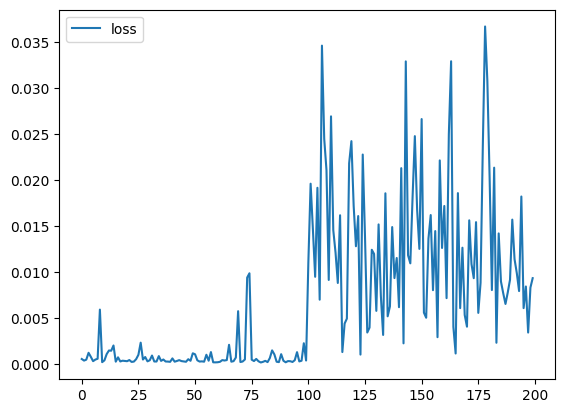

In [12]:
df.plot()